# Text Classification with LaBSE


# Connect To Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### Install a pip package

In [5]:
!pip install bert-for-tf2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30515 sha256=8f876193e9ea0287b546195541aba499e3e5ca52e91a2da1077b619375201652
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19457 sha256=f65631567b67b62a6ac97f9e93b99aa87306c96c58b339967c7f2bb493834dc6
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7892 sha256=eb662f252dace265cb5bf268a2dd75a1b20266c507f747c34012f1cb21adc363
  Sto

In [ ]:
# ! pip install qgridv

In [ ]:
# !pip install -q transformers
# !pip install -q hazm
# !pip install -q clean-text[gpl]

In [ ]:
# ! pip install clean-text

In [ ]:
# ! pip install openpyxl

In [ ]:
# ! conda install -c anaconda openpyxl

### Imports

In [ ]:
! pip install bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import bert
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

# import hazm
# from cleantext import clean

# import plotly.express as px
# import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import json
import copy
import collections

### Resources

You can get a pre-trained LaBSE model from TensorFlow Hub here:

In [2]:
model_url = 'https://tfhub.dev/google/LaBSE/1'
labse_layer = hub.KerasLayer(model_url, trainable=True)

## The dataset

For this example we used the sentipers Dataset.

Load the data using Pandas

In [29]:
sentiper = pd.read_excel('/content/drive/MyDrive/data/sentipers.xlsx')
sentiper.head()

,text,polarity
0,اینک قصد داریم پرینتر دیگری از پرینترهای لیزری...,neutral
1,پرینتری چند کاره از رده‌ی Entry Level یا سطح م...,neutral
2,به هر صورت اکنون ما در دنیایی زندگی می‌کنیم، ...,neutral
3,به صورتی که توانایی کپی کردن، اسکن، فکس، پر...,neutral
4,به هر صورت معمولا چیزی که بیشتر کاربران از پری...,very good


Fixing Conflicts

For simplicity, I fix this problem by removing rows with the rate value of None. Furthermore, the dataset contains duplicated rows and missing values in the comment section.

In [ ]:
# print data information
print('data information')
print(sentiper.info(), '\n')

# print missing values information
print('missing values stats')
print(sentiper.isnull().sum(), '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15683 entries, 0 to 15682
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      15683 non-null  object
 1   polarity  15683 non-null  object
dtypes: object(2)
memory usage: 245.2+ KB
None 

missing values stats
text        0
polarity    0
dtype: int64 



Normalization / Preprocessing

The comments have different lengths based on words! Detecting the most normal range could help us find the maximum length of the sequences for the preprocessing step. On the other hand, we suppose that the minimum word combination for having a meaningful phrase for our learning process is 3.

In [ ]:
# calculate the length of comments based on their words
sentiper['text_len_by_words'] = sentiper['text'].apply(lambda t: len(hazm.word_tokenize(t)))

In [ ]:
min_max_len = sentiper["text_len_by_words"].min(), sentiper["text_len_by_words"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 1 	Max: 339


In [ ]:
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='text_len_by_words'):
    data_length = data[col].values

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    data_glt_rate = (data_glt / len(data_length)) * 100

    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

In [ ]:
data_gl_than(sentiper, 75, 3)

Texts with word length of greater than 3 and less than 75 includes 95.95% of the whole!


In [ ]:
minlim, maxlim = 3, 75

In [ ]:
# remove comments with the length of fewer than three words and more than 75
sentiper['text_len_by_words'] = sentiper['text_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
sentiper = sentiper.dropna(subset=['text_len_by_words'])
sentiper = sentiper.reset_index(drop=True)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=sentiper['text_len_by_words']))

fig.update_layout(
    title_text='Distribution of word counts within comments',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [ ]:
unique_rates = list(sorted(sentiper['polarity'].unique()))
print(f'We have #{len(unique_rates)}: {unique_rates}')

We have #5: ['bad', 'good', 'neutral', 'very bad', 'very good']


In [ ]:
fig = go.Figure()

groupby_rate = sentiper.groupby('polarity')['polarity'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments',
    xaxis_title_text='Polarity',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

Cleaning is the final step in this section. Our cleaned method includes these steps:

- fixing unicodes
- removing specials like a phone number, email, url, new lines, ...
- cleaning HTMLs
- normalizing
- removing emojis

In [ ]:
sentiper = sentiper.drop_duplicates()

In [ ]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [ ]:
# cleaning comments
sentiper['cleaned_text'] = sentiper['text'].apply(cleaning)


# calculate the length of comments based on their words
sentiper['cleaned_text_len_by_words'] = sentiper['cleaned_text'].apply(lambda t: len(hazm.word_tokenize(t)))

# remove comments with the length of fewer than three words
sentiper['cleaned_text_len_by_words'] = sentiper['cleaned_text_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
sentiper = sentiper.dropna(subset=['cleaned_text_len_by_words'])
sentiper = sentiper.reset_index(drop=True)

sentiper.head()

,text,polarity,text_len_by_words,cleaned_text,cleaned_text_len_by_words
0,اینک قصد داریم پرینتر دیگری از پرینترهای لیزری...,neutral,14.0,اینک قصد داریم پرینتر دیگری از پرینترهای لیزری...,14
1,پرینتری چند کاره از رده‌ی Entry Level یا سطح م...,neutral,11.0,پرینتری چند کاره از رده‌ی entry level یا سطح م...,11
2,به هر صورت اکنون ما در دنیایی زندگی می‌کنیم، ...,neutral,25.0,به هر صورت اکنون ما در دنیایی زندگی می‌کنیم، ک...,25
3,به صورتی که توانایی کپی کردن، اسکن، فکس، پر...,neutral,29.0,به صورتی که توانایی کپی کردن، اسکن، فکس، پرینت...,29
4,به هر صورت معمولا چیزی که بیشتر کاربران از پری...,very good,42.0,به هر صورت معمولا چیزی که بیشتر کاربران از پری...,41


In [ ]:
sentiper = sentiper[['cleaned_text', 'polarity']]
sentiper.columns = ['text', 'polarity']
sentiper.head()

,text,polarity
0,اینک قصد داریم پرینتر دیگری از پرینترهای لیزری...,neutral
1,پرینتری چند کاره از رده‌ی entry level یا سطح م...,neutral
2,به هر صورت اکنون ما در دنیایی زندگی می‌کنیم، ک...,neutral
3,به صورتی که توانایی کپی کردن، اسکن، فکس، پرینت...,neutral
4,به هر صورت معمولا چیزی که بیشتر کاربران از پری...,very good


Save cleaned data

In [ ]:
# sentiper.to_csv("/content/drive/MyDrive/data/cleaned_sentipers.xlsx")  
sentiper.to_csv("data/datasets/cleaned_sentipers.csv") 


Load cleaned data

In [ ]:
sentiper = pd.read_csv('/content/drive/MyDrive/MSC/NaturalLanguage/cleaned_sentipers.csv')
# sentiper = pd.read_csv('data/datasets/cleaned_sentipers.xlsx')


In [ ]:
sentiper.shape

(15048, 3)

In [ ]:
sentiper.head()

,Unnamed: 0,text,polarity
0,0,اینک قصد داریم پرینتر دیگری از پرینترهای لیزری...,neutral
1,1,پرینتری چند کاره از رده‌ی entry level یا سطح م...,neutral
2,2,به هر صورت اکنون ما در دنیایی زندگی می‌کنیم، ک...,neutral
3,3,به صورتی که توانایی کپی کردن، اسکن، فکس، پرینت...,neutral
4,4,به هر صورت معمولا چیزی که بیشتر کاربران از پری...,very good


In [ ]:
sentiper = sentiper.drop("Unnamed: 0", axis=1)
sentiper.shape

(15048, 2)

### map labels to integers

In [38]:
label_map = {"very bad": 0, "bad": 1, "neutral": 2, "good": 3, "very good": 4}

def map_labels_to_int(df, label_map):
    df["polarity"] = df["polarity"].replace(label_map, inplace=False)
    return df

sentiper = map_labels_to_int(sentiper, label_map)
sentiper.head()


,text,polarity
0,اینک قصد داریم پرینتر دیگری از پرینترهای لیزری...,2
1,پرینتری چند کاره از رده‌ی Entry Level یا سطح م...,2
2,به هر صورت اکنون ما در دنیایی زندگی می‌کنیم، ...,2
3,به صورتی که توانایی کپی کردن، اسکن، فکس، پر...,2
4,به هر صورت معمولا چیزی که بیشتر کاربران از پری...,4


In [39]:
from sklearn.model_selection import train_test_split


# train, val = train_test_split(sentiper, test_size=.1, shuffle=False)
# train, test = train_test_split(train, test_size=.1, shuffle=False)

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the number of samples for each split
num_samples = sentiper.shape[0]
num_train = int(num_samples * train_ratio)
num_val = int(num_samples * val_ratio)
num_test = num_samples - num_train - num_val

# Create the indices for each split
train_indices = range(num_train)
val_indices = range(num_train, num_train + num_val)
test_indices = range(num_train + num_val, num_samples)

# Split the dataset based on the indices
train = sentiper.iloc[train_indices]
val = sentiper.iloc[val_indices]
test = sentiper.iloc[test_indices]

In [ ]:
print(train.shape, val.shape, test.shape)

(12546, 2) (1568, 2) (1569, 2)


### The BERT Tokenizer

In [ ]:
# ! pip install bert-tensorflow

In [8]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.5 MB/s eta 0:00:00


In [3]:
from transformers import BertTokenizer

# Load the BERT vocabulary
vocab_file = labse_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = labse_layer.resolved_object.do_lower_case.numpy()

# Create the tokenizer using the BERT vocabulary
tokenizer = BertTokenizer(vocab_file, do_lower_case=do_lower_case)


### Preprocess the datasets

In [11]:
max_seq_length = 128


def create_input(input_strings, tokenizer, max_seq_length):
    input_ids_all, input_mask_all, segment_ids_all = [], [], []
    for input_string in input_strings:
        
        # Tokenize input.
        input_tokens = ['[CLS]'] + tokenizer.tokenize(input_string) + ['[SEP]'] # A list of input strings to be tokenized and encoded.
        input_ids = tokenizer.convert_tokens_to_ids(input_tokens) # A tokenizer object that converts input text to tokens.
        sequence_length = min(len(input_ids), max_seq_length) # The maximum sequence length for the input.

        # Padding or truncation.
        if len(input_ids) >= max_seq_length:
          input_ids = input_ids[:max_seq_length]
        else:
          input_ids = input_ids + [0] * (max_seq_length - len(input_ids))

        input_mask = [1] * sequence_length + [0] * (max_seq_length - sequence_length)

        input_ids_all.append(input_ids)
        input_mask_all.append(input_mask)
        segment_ids_all.append([0] * max_seq_length)

    return np.array(input_ids_all), np.array(input_mask_all), np.array(segment_ids_all)

In [40]:
train_inputs = create_input(train.text.values, tokenizer, max_seq_length)
validation_inputs = create_input(val.text.values, tokenizer, max_seq_length)
test_inputs = create_input(test.text.values, tokenizer, max_seq_length)

train_data = tf.data.Dataset.from_tensor_slices((train_inputs, train.polarity.values))
validation_data = tf.data.Dataset.from_tensor_slices((validation_inputs, val.polarity.values))
test_data = tf.data.Dataset.from_tensor_slices((test_inputs, test.polarity.values))

In [ ]:
val.shape

(1568, 2)

## The model

### Build the model

In [19]:
def get_model(labse_layer, max_seq_length, num_labels, rate=0.1):
    input_word_ids = tf.keras.layers.Input(
        shape=(max_seq_length,),
        dtype=tf.int32,
        name='input_word_ids'
    )
    input_mask = tf.keras.layers.Input(
        shape=(max_seq_length,),
        dtype=tf.int32,
        name='input_mask'
    )
    segment_ids = tf.keras.layers.Input(
        shape=(max_seq_length,),
        dtype=tf.int32,
        name='segment_ids'
    )

    pooled_output,  _ = labse_layer([input_word_ids, input_mask, segment_ids])
    pooled_output = tf.keras.layers.Dropout(rate=rate)(pooled_output)
    output = tf.keras.layers.Dense(units=num_labels, activation='softmax')(pooled_output)

    return tf.keras.Model(
                inputs=[input_word_ids, input_mask, segment_ids],
                outputs=output
            )


num_labels = 5
model = get_model(
    labse_layer,
    max_seq_length=max_seq_length,
    num_labels=num_labels
)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        470926849   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

### Train the model

In [23]:
epochs = 5
batch_size = 16
save_path = '/content/drive/MyDrive/MSC/NaturalLanguage/model'

model.compile(
    optimizer='sgd',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
             tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
    ]
)

model.fit(
      train_data.batch(batch_size),
      validation_data=validation_data.batch(batch_size),
      epochs=epochs,
      callbacks=[
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
                 tf.keras.callbacks.ModelCheckpoint(
                     filepath=save_path,
                     monitor='val_loss',
                     save_best_only=True,
                     mode='min'
                 )
      ]
)

Epoch 1/5
785/785 [==============================] - ETA: 0s - loss: 0.8174 - accuracy: 0.6718

785/785 [==============================] - 503s 598ms/step - loss: 0.8174 - accuracy: 0.6718 - val_loss: 0.8205 - val_accuracy: 0.6773
Epoch 2/5
785/785 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.7527

785/785 [==============================] - 659s 839ms/step - loss: 0.6159 - accuracy: 0.7527 - val_loss: 0.7301 - val_accuracy: 0.7143
Epoch 3/5
785/785 [==============================] - ETA: 0s - loss: 0.5238 - accuracy: 0.7912

785/785 [==============================] - 768s 979ms/step - loss: 0.5238 - accuracy: 0.7912 - val_loss: 0.7186 - val_accuracy: 0.7302
Epoch 4/5
785/785 [==============================] - 377s 481ms/step - loss: 0.4477 - accuracy: 0.8238 - val_loss: 0.7643 - val_accuracy: 0.7200
Epoch 5/5
785/785 [==============================] - 375s 478ms/step - loss: 0.3883 - accuracy: 0.8483 - val_loss: 0.8359 - val_accuracy: 0.7219


### Load the trained model

In [5]:
save_path = '/content/drive/MyDrive/MSC/NaturalLanguage/model'
#model = tf.keras.models.load_model(save_path)

In [6]:
model = tf.keras.models.load_model(save_path)

### Evaluate the model

In [41]:
y_pred = model.predict(test_inputs, batch_size=batch_size)

99/99 [==============================] - 13s 134ms/step


In [27]:
accuracy_score(
    y_true=test.polarity.values,
    y_pred=np.argmax(y_pred, axis=-1)
)

0.6998087954110899

In [42]:
from sklearn.metrics import classification_report

y_pred=np.argmax(y_pred, axis=-1)
y_true=test.polarity.values

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.17      0.89      0.28        18
           1       0.46      0.61      0.53       127
           2       0.86      0.59      0.70       550
           3       0.54      0.83      0.65       599
           4       0.50      0.00      0.01       275

    accuracy                           0.59      1569
   macro avg       0.51      0.59      0.43      1569
weighted avg       0.63      0.59      0.54      1569



In [44]:
from sklearn.metrics import confusion_matrix
def print_confusion_matrix(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    ax = plt.subplot()
    sns.heatmap(conf_mat, annot = True, ax = ax, linewidths = 5, linecolor = 'y', center = 0)
    ax.set_title(f"Confusion Matrix for Final Model")
    ax.set_xlabel('Predicted Labels') 
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['very bad', 'bad', 'neutral', 'good', 'very good"'  ])
    ax.yaxis.set_ticklabels(['very bad', 'bad', 'neutral', 'good', 'very good"'  ])
    plt.show()

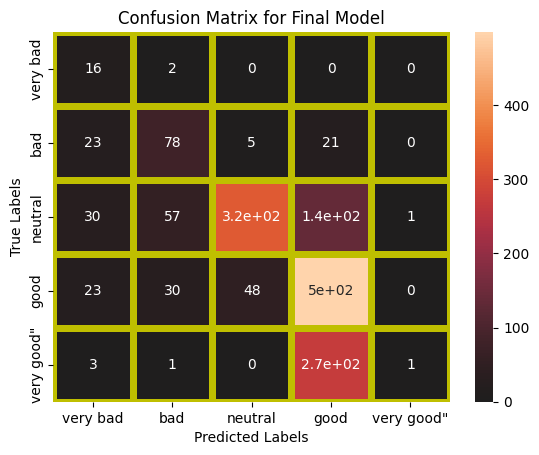

In [45]:
print_confusion_matrix(y_true, y_pred)

Part 2 use snapfood dataset to test preivous model

As a result of zero-shot learning, NLP models can perform well on tasks or domains for which they have not been explicitly trained. In contrast to traditional models that require specialized training, zero-shot learning uses pre-trained language models that have learned general language representations from a variety of sources. By capturing linguistic patterns and semantic relationships, these models provide a foundation for understanding language. By using pre-trained knowledge, zero-shot learning refines the model with minimal task-specific annotations or examples. Using this approach, models can be generalized to new tasks without requiring extensive task-specific data. With zero-shot learning, NLP models can be applied to a wide range of tasks and domains, enabling flexibility and adaptability.

Load dataset

In [7]:
snap = pd.read_csv("/content/drive/MyDrive/data/snapfood_testset.csv")
snap.head()

,comment,label
0,خواهشا خواهشا خواهشا واسه ارسال شیرینیها یه فک...,HAPPY
1,غذا گرم رسید کیفیت و پخت گوشت عالی بود,HAPPY
2,قیمت سس شکلات روی بسته بندی ۱۵۰۰۰ بود ولی قیمت...,SAD
3,عکس توی پیج یه شیرینی شکری روشن رنگ هست که همم...,SAD
4,باز هم میگم، پیتزا نباید اینقد چرب باشه,SAD


In [8]:
label_map = {"HAPPY": 0, "SAD": 1}

def map_labels_to_int_snap(df, label_map):
    df["label"] = df["label"].replace(label_map, inplace=False)
    return df

snap = map_labels_to_int_snap(snap, label_map)
snap.head()

,comment,label
0,خواهشا خواهشا خواهشا واسه ارسال شیرینیها یه فک...,0
1,غذا گرم رسید کیفیت و پخت گوشت عالی بود,0
2,قیمت سس شکلات روی بسته بندی ۱۵۰۰۰ بود ولی قیمت...,1
3,عکس توی پیج یه شیرینی شکری روشن رنگ هست که همم...,1
4,باز هم میگم، پیتزا نباید اینقد چرب باشه,1


In [9]:
from sklearn.model_selection import train_test_split


s_train, s_val = train_test_split(snap, test_size=.1, shuffle=False)
s_train, s_test = train_test_split(s_train, test_size=.1, shuffle=False)


In [12]:
s_train_inputs = create_input(s_train.comment.values, tokenizer, max_seq_length)
s_validation_inputs = create_input(s_val.comment.values, tokenizer, max_seq_length)
s_test_inputs = create_input(s_test.comment.values, tokenizer, max_seq_length)

s_train_data = tf.data.Dataset.from_tensor_slices((s_train_inputs, s_train.label.values))
s_validation_data = tf.data.Dataset.from_tensor_slices((s_validation_inputs, s_val.label.values))
s_test_data = tf.data.Dataset.from_tensor_slices((s_test_inputs, s_test.label.values))

In [13]:
from tensorflow.keras.layers import Dense, Dropout

# Define the inputs
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_mask')
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='segment_ids')

# Pass the inputs through the model
output = model([input_word_ids, input_mask, segment_ids])

# Add additional layers
dense1 = Dense(128, activation='relu')(output)
dropout = Dropout(0.2)(dense1)
dense2 = Dense(64, activation='relu')(dropout)

# Add a dense layer with 2 units and a softmax activation for multi-class classification
dense = Dense(2, activation='softmax')(dense2)

# Create the final model with inputs and outputs
model_final = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=dense)

for layer in model_final.layers[:4]:
    layer.trainable = False


In [ ]:
model_final.summary()

In [15]:
epochs = 3
batch_size = 16
save_path = '/content/drive/MyDrive/data/model2'

model_final.compile(
    optimizer='sgd',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
             tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
    ]
)

model_final.fit(
      s_train_data.batch(batch_size),
      validation_data=s_validation_data.batch(batch_size),
      epochs=epochs,
      callbacks=[
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
                 tf.keras.callbacks.ModelCheckpoint(
                     filepath=save_path,
                     monitor='val_loss',
                     save_best_only=True,
                     mode='min'
                 )
      ]
)

Epoch 1/3
355/355 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.7914

355/355 [==============================] - 519s 1s/step - loss: 0.5491 - accuracy: 0.7914 - val_loss: 0.3948 - val_accuracy: 0.8643
Epoch 2/3
355/355 [==============================] - ETA: 0s - loss: 0.3676 - accuracy: 0.8619

355/355 [==============================] - 561s 2s/step - loss: 0.3676 - accuracy: 0.8619 - val_loss: 0.3466 - val_accuracy: 0.8771
Epoch 3/3
355/355 [==============================] - ETA: 0s - loss: 0.3195 - accuracy: 0.8732

355/355 [==============================] - 657s 2s/step - loss: 0.3195 - accuracy: 0.8732 - val_loss: 0.3321 - val_accuracy: 0.8757


In [16]:
save_path = '/content/drive/MyDrive/data/model2'
model_final = tf.keras.models.load_model(save_path)

In [17]:
model_final = tf.keras.models.load_model(save_path)

In [20]:
from sklearn.metrics import classification_report
X = s_test.comment
y = s_test.label

X_encoded = tokenizer.batch_encode_plus(X, padding=True, truncation=True, max_length=max_seq_length, return_tensors="tf")
input_word_ids = X_encoded["input_ids"]
input_mask = X_encoded["attention_mask"]
segment_ids = X_encoded["token_type_ids"]

y_pred = model_final.predict([input_word_ids, input_mask, segment_ids], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y, y_pred_bool))


40/40 [==============================] - 6s 133ms/step
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       303
           1       0.85      0.83      0.84       327

    accuracy                           0.84       630
   macro avg       0.84      0.84      0.84       630
weighted avg       0.84      0.84      0.84       630



In [25]:
from sklearn.metrics import confusion_matrix
def print_confusion_matrix(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    ax = plt.subplot()
    sns.heatmap(conf_mat, annot = True, ax = ax, linewidths = 5, linecolor = 'y', center = 0)
    ax.set_title(f"Confusion Matrix for Final Model")
    ax.set_xlabel('Predicted Labels') 
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Happy', 'Bad'])
    ax.yaxis.set_ticklabels(['Happy', 'Bad'])
    plt.show()

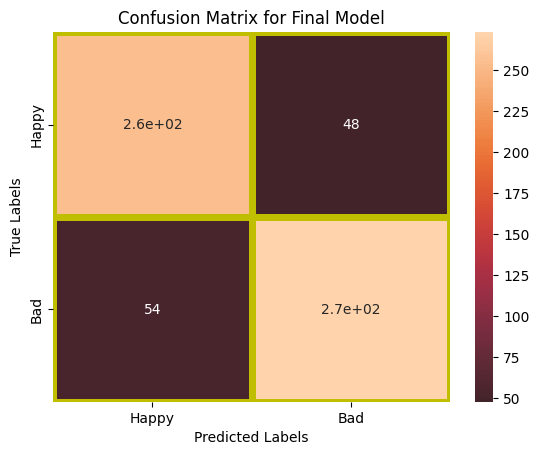

In [26]:
print_confusion_matrix(y, y_pred_bool)